In [102]:
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import copy
import itertools
from scipy.optimize import minimize
from scipy import linalg
import math
import time
np.random.seed(333)

In [103]:
# load W and V from bilinear model
V = np.load('V.npy',allow_pickle=True) # dictionary keyed by pedigree type, each entry has dimension 1 x k
print('V',V)
W = np.load('W.npy',allow_pickle=True)
print('W shape', W)

V {'F42/H95': array([-0.134102  , -0.43153935,  0.13433148,  0.31237745,  0.26993498,
        0.14613926,  0.50473704,  0.24550396, -0.09367974, -0.88036623]), 'B14A/H95': array([-0.00373503, -0.31066923,  0.0667453 ,  0.37055342,  0.32443576,
        0.19294431,  0.58770223,  0.34647183, -0.11208985, -0.66014258]), 'LH195/LH185': array([ 0.07776899, -0.55310634,  0.11748689,  0.38221518,  0.20672213,
        0.08693101,  0.70998443,  0.35083119, -0.22604078, -0.82967089]), 'PHW52/PHN82': array([-0.06962095, -0.60010672,  0.08046336,  0.54343921,  0.38430025,
        0.14020703,  0.71526137,  0.28485348, -0.28893587, -0.72895628]), 'B73/PHN82': array([-0.06436341, -0.58304879,  0.15500911,  0.39840092,  0.24757156,
        0.15311275,  0.70561628,  0.34683787, -0.18381003, -0.75223923]), 'PHW52/TX205': array([-0.02853664, -0.47407234,  0.17515551,  0.4531595 ,  0.21973102,
        0.36480329,  0.62056102,  0.37240784, -0.251808  , -0.62398233]), 'PHG39/PHN82': array([-0.12480104, -0.54

In [104]:
# load subset of data used to train bilinear model
subset_df = pd.read_csv("subset_data.csv") 
subset_df = subset_df.iloc[: , 1:]
subset_df

,Field-Location_x,Pedigree_x,Plot Yield (ibs/ft2),% Sand,% Silt,% Clay,v_daily_avg_temp,v_daily_avg_radiation,v_daily_avg_photo_p,Loc-ID-Onehot
0,OHH1,F42/H95,0.240000,0.23,0.46,0.31,0.213058,0.81445,0.1525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,OHH1,B14A/H95,0.206222,0.23,0.46,0.31,0.213058,0.81445,0.1525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,OHH1,LH195/LH185,0.267556,0.23,0.46,0.31,0.213058,0.81445,0.1525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OHH1,PHW52/PHN82,0.224889,0.23,0.46,0.31,0.213058,0.81445,0.1525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,OHH1,B73/PHN82,0.220444,0.23,0.46,0.31,0.213058,0.81445,0.1525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
2153,TXH2,F42/OH43,0.172308,0.38,0.34,0.28,0.175102,0.67950,0.1200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2154,TXH2,B14A/OH43,0.171125,0.38,0.34,0.28,0.175102,0.67950,0.1200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2155,TXH2,B37/MO17,0.146100,0.38,0.34,0.28,0.175102,0.67950,0.1200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2156,TXH2,B73/PHM49,0.179574,0.38,0.34,0.28,0.175102,0.67950,0.1200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [105]:
# extract field names, seed names and field x seed name combinations
field_id = list(set(subset_df['Field-Location_x'].tolist()))
seed_id = list(set(subset_df['Pedigree_x'].tolist()))
seedxfield = list(itertools.product(seed_id, field_id))
print('Example of seed and field combination:', seedxfield[0])
stats = []
# printing the number of data points we have for each field x seed combination
for seed, field in seedxfield:
  l = len(subset_df[(subset_df['Field-Location_x']==field) & (subset_df['Pedigree_x']==seed)])
  stats.append(l)
print('Possible datapoints for each unique seed and field combinations', set(stats))


Example of seed and field combination: ('F42/OH43', 'INH1')
Possible datapoints for each unique seed and field combinations {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 19, 23, 32}


In [106]:
# generating list of valid seed x field combinations
valid_seedxfield = []
for seed, field in seedxfield:
  if len(subset_df[(subset_df['Field-Location_x']==field) & (subset_df['Pedigree_x']==seed)]) > 0:
    valid_seedxfield.append((seed,field))
print('Total field x seed combinations:',len(seedxfield))
print('Number of field x seed combination we have:',len(valid_seedxfield))

Total field x seed combinations: 552
Number of field x seed combination we have: 424


In [107]:
# get the empirical variance for each seed x field combination 
features = ['% Sand',	'% Silt',	'% Clay',	'v_daily_avg_temp',	'v_daily_avg_radiation', 'v_daily_avg_photo_p']
variance_dict = dict()
var_df = pd.DataFrame()
for idx, item in enumerate(valid_seedxfield):
    # calculate variance only when more than 1 datapoint, else will create NaN values
    if len(subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])][features]) > 1:
      variance_dict[item] = subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])][features].var()
      var_df[item] = subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])][features].var()

# example variance of features for specific seed and field
print('Number of seed x field combination with variance:',len(variance_dict))


/tmp/ipykernel_9167/2541872252.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_df[item] = subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])][features].var()
/tmp/ipykernel_9167/2541872252.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_df[item] = subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])][features].var()
/tmp/ipykernel_9167/2541872252.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Number of seed x field combination with variance: 414


/tmp/ipykernel_9167/2541872252.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_df[item] = subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])][features].var()
/tmp/ipykernel_9167/2541872252.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_df[item] = subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])][features].var()
/tmp/ipykernel_9167/2541872252.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [108]:
subset_df[(subset_df['Field-Location_x']==item[1]) & (subset_df['Pedigree_x']==item[0])]


,Field-Location_x,Pedigree_x,Plot Yield (ibs/ft2),% Sand,% Silt,% Clay,v_daily_avg_temp,v_daily_avg_radiation,v_daily_avg_photo_p,Loc-ID-Onehot
338,GAH1,LH195/LH185,0.234881,0.81,0.11,0.08,0.207677,0.5497,0.1342,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
348,GAH1,LH195/LH185,0.091786,0.81,0.11,0.08,0.207677,0.5497,0.1342,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
422,GAH1,LH195/LH185,0.170833,0.79,0.11,0.10,0.194854,0.0643,0.1323,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
450,GAH1,LH195/LH185,0.196905,0.79,0.11,0.10,0.194854,0.0643,0.1323,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [109]:
var_df = var_df.transpose()
var_df.describe()
var_df

,% Sand,% Silt,% Clay,v_daily_avg_temp,v_daily_avg_radiation,v_daily_avg_photo_p
"(F42/OH43, INH1)",0.002020,1.080000e-03,0.005380,2.823146e-04,0.005574,1.728020e-04
"(F42/OH43, MNH1)",0.000025,3.221556e-33,0.000025,2.948492e-04,0.002814,2.630188e-04
"(F42/OH43, NEH2)",0.000000,0.000000e+00,0.000000,7.050781e-09,0.019741,0.000000e+00
"(F42/OH43, DEH1)",0.000960,4.266667e-04,0.000107,2.532942e-03,0.023097,1.198507e-04
"(F42/OH43, OHH1)",0.000129,2.800000e-03,0.001729,4.837667e-05,0.000021,1.508929e-04
...,...,...,...,...,...,...
"(LH195/LH185, WIH2)",0.002700,5.333333e-04,0.000833,1.098732e-03,0.000000,4.563333e-06
"(LH195/LH185, IAH1)",0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
"(LH195/LH185, WIH1)",0.000133,1.633333e-03,0.002700,6.394083e-05,0.123647,4.800000e-07
"(LH195/LH185, ILH1)",0.000033,1.633333e-03,0.002133,9.071152e-04,0.056918,7.409167e-06


In [110]:
# generating dataset by adding noise from N(0, var)
noisy_df = subset_df.copy()
features = ['% Sand',	'% Silt',	'% Clay',	'v_daily_avg_temp',	'v_daily_avg_radiation', 'v_daily_avg_photo_p']
for idx, row in noisy_df.iterrows():
  # var is a row of variance for specific seed and field_id, where each column correspondes to variance of feature
  # we only add noise to those seed and field_id that has multiple datapoints (i.e., with variance)
  try:
    var = variance_dict[(row['Pedigree_x'],row['Field-Location_x'])]
    # iterate over sand, silt, clay, avg_t, avg_r, avg_p
    for f in features:
#       noisy_df.at[idx,f] = float(noisy_df.at[idx,f]) + np.random.normal(0, np.sqrt(var[f]))
      noisy_df.at[idx,f] = float(noisy_df.at[idx,f]) + np.random.normal(0, 1e-1)
#       noisy_df.at[idx,f] = float(noisy_df.at[idx,f]) + 0
  except:
    pass
noisy_df

,Field-Location_x,Pedigree_x,Plot Yield (ibs/ft2),% Sand,% Silt,% Clay,v_daily_avg_temp,v_daily_avg_radiation,v_daily_avg_photo_p,Loc-ID-Onehot
0,OHH1,F42/H95,0.240000,0.401718,0.492469,0.262546,0.199267,0.866944,0.116716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,OHH1,B14A/H95,0.206222,0.157180,0.395791,0.278295,0.091158,0.809252,0.221903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,OHH1,LH195/LH185,0.267556,0.217640,0.637362,0.337269,0.191763,0.767129,0.121150,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OHH1,PHW52/PHN82,0.224889,0.392167,0.531795,0.097819,0.188800,0.731769,0.024754,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,OHH1,B73/PHN82,0.220444,0.261806,0.486717,0.492559,0.228306,0.866508,0.040338,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
2153,TXH2,F42/OH43,0.172308,0.162670,0.241895,0.271593,0.017732,0.541151,0.141018,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2154,TXH2,B14A/OH43,0.171125,0.549354,0.241464,0.313319,0.090627,0.738325,0.111696,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2155,TXH2,B37/MO17,0.146100,0.439381,0.490340,0.316471,0.222554,0.702157,0.139542,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2156,TXH2,B73/PHM49,0.179574,0.408879,0.417080,0.236906,0.253060,0.812996,0.045684,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [111]:
# check if any NaN values in dataset
noisy_df.isna().all()


Field-Location_x         False
Pedigree_x               False
Plot Yield (ibs/ft2)     False
% Sand                   False
% Silt                   False
% Clay                   False
v_daily_avg_temp         False
v_daily_avg_radiation    False
v_daily_avg_photo_p      False
Loc-ID-Onehot            False
dtype: bool

In [112]:
# checking if noisy dataset is different from original dataset
(noisy_df[['% Sand',	'% Silt',	'% Clay',	'v_daily_avg_temp',	'v_daily_avg_radiation', 'v_daily_avg_photo_p']] - subset_df[['% Sand',	'% Silt',	'% Clay',	'v_daily_avg_temp',	'v_daily_avg_radiation', 'v_daily_avg_photo_p']]).describe()

,% Sand,% Silt,% Clay,v_daily_avg_temp,v_daily_avg_radiation,v_daily_avg_photo_p
count,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000
mean,-0.001540,0.003856,0.000108,-0.002933,0.001972,-0.000048
std,0.099421,0.098389,0.098439,0.097536,0.099753,0.099148
min,-0.356205,-0.337802,-0.409431,-0.357568,-0.359739,-0.311862
25%,-0.069078,-0.060950,-0.066783,-0.069032,-0.066092,-0.067311
50%,-0.000160,0.003787,0.000742,-0.001863,0.002235,0.000991
75%,0.063370,0.068948,0.064909,0.061890,0.070230,0.067119
max,0.324347,0.347100,0.347035,0.287169,0.305698,0.295010


In [113]:
# constructing obs from clean features and one-hot encoding of field-idx
obs_raw = subset_df[['Loc-ID-Onehot','% Sand', '% Silt', '% Clay', 'v_daily_avg_temp', 'v_daily_avg_radiation', 'v_daily_avg_photo_p']]
obs_raw = obs_raw.to_numpy()
for i in range(len(obs_raw)):
  obs_raw[i][0] = obs_raw[i][0].strip('][').split(', ')

obs = []
for i in range(len(obs_raw)):
  obs.append(list([int(id) for id in obs_raw[i][0]]) + list(obs_raw[i][1:]))
obs = np.asarray(obs)
print('obs shape:',obs.shape)
print('First 5 rows of obs:')
print(obs[0:5])
np.isnan(np.sum(obs))

obs shape: (2158, 29)
First 5 rows of obs:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.23
  0.46       0.31       0.21305833 0.81445    0.1525    ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.23
  0.46       0.31       0.21305833 0.81445    0.1525    ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.23
  0.46       0.31       0.21305833 0.81445    0.1525    ]
 [0.         0.         0.         0.         0.         

False

In [114]:
# constructing mu from noisy features and one-hot encoding of field-idx
mu_raw = noisy_df[['Loc-ID-Onehot','% Sand', '% Silt', '% Clay', 'v_daily_avg_temp', 'v_daily_avg_radiation', 'v_daily_avg_photo_p']]
mu_raw = mu_raw.to_numpy()

for i in range(len(mu_raw)):
  mu_raw[i][0] = mu_raw[i][0].strip('][').split(', ')

mu = []
for i in range(len(mu_raw)):
  mu.append(list([int(id) for id in mu_raw[i][0]]) + list(mu_raw[i][1:]))
mu = np.asarray(mu)
print('mu shape:',mu.shape)
print('First 5 rows of mu:')
print(mu[0:5])
np.isnan(np.sum(mu))

mu shape: (2158, 29)
First 5 rows of mu:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.40171843
  0.49246933 0.26254566 0.1992665  0.86694396 0.11671642]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.15717951
  0.39579135 0.27829523 0.09115819 0.80925197 0.22190273]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.21764022
  0.63736171 0.33726925 0.19176251 0.76712876 0.12114989]
 [0.         0.         0.         0.    

False

In [115]:
# utility functions

# extract field id from mu and queries baseline yield
def query_baseline(sample_mu, baseline_rank):
  field_names = ['COH1', 'DEH1', 'GAH1', 'GAH2', 'IAH1', 'IAH2', 'IAH4', 'ILH1', 'INH1', 'MIH1', 'MNH1', 'NEH1', 'NEH2', 'NYH1', 'NYH2', 'NYH3', 'OHH1', 'ONH1', 'ONH2', 'TXH1', 'TXH2', 'WIH1', 'WIH2']
  # extract field ID given 1-hot positions (argmax)
  field_idx = field_names[np.argmax(sample_mu[0:23])]

  if baseline_rank == -1:
    # take average yield for given location
    baseline = np.mean(noisy_df.loc[noisy_df['Field-Location_x'] == field_idx]['Plot Yield (ibs/ft2)'])
  else:
    baseline = noisy_df.loc[noisy_df['Field-Location_x'] == field_idx]['Plot Yield (ibs/ft2)']
    baseline = baseline.sort_values(ascending=False)
    try:
      baseline = baseline.iloc[baseline_rank]
    except:
      baseline = baseline.iloc[-1]
  return baseline, field_idx

# generates a block diagonal psi, with shape (n_actions, n_action*k)
def generate_psi(psi,n_actions,k):
  big_psi = np.zeros((n_actions, n_actions*k))
  #print(big_psi.shape)
  start = 0
  end = k
  for i in range(n_actions):
    big_psi[i][start:end] = psi
    start += k
    end += k
  return big_psi

# compute theta_bar from Eqn 4
def compute_theta_bar(psi_mat, y_mat):
    # print('Psi matrix:',psi_mat.shape)
    # print('Y matrix:',y_mat.shape)
    theta_bar = linalg.inv(psi_mat.dot(psi_mat.T) + ld*np.eye(240)).dot(psi_mat).dot(y_mat)
    # print('Theta bar:',theta_bar.shape)
    return theta_bar

# compute beta from Eqn 5
def compute_beta(S_x):
  ld = 0.1 
  A = 1
  D = 1 #not implemented in argmax x, need to verify how D comes into play in assumption 2, need to enforce in Bilinear model
  m_t = sum([len(value) for value in S_x.values()]) #number of times bandit decision was played
  delta = 0.001 # confidence parameter (can be changed)
  sigma = 1 # noise for reward, assume really small
  d = 240 # dimension of theta
  beta = sigma*np.sqrt(d*np.log((1+((m_t + 1)*(D**2)/ld))/delta)) + np.sqrt(ld)*A
  print('Computing beta:',beta)
  return beta

In [116]:
# objective function for maximization
def maximize_reward(theta_hat):
# print('diag',diag_psi.shape)
# print('theta',theta_hat.shape)
  return np.min(-1.0*diag_psi.dot(theta_hat)) #returns minimum of(n_actions,1)

# enforces that r > -1
def max_c1(theta_hat):
  return 1+maximize_reward(theta_hat)

# enforces that r < 0
def max_c2(theta_hat):
  return -1.0*maximize_reward(theta_hat)

#enforces that || theta || < A
def max_c3(theta_hat):
  A = 1.0
  return A - np.linalg.norm(theta_hat)

# enforces Eqn 5
def max_norm(theta_hat):
    A = 1.0
    # print('theta_hat:',theta_hat.shape)
    # print('theta_bar:',theta_bar.shape)
    theta_hat = np.expand_dims(theta_hat,1)
    u = theta_hat - theta_bar
    # print('u:',u.shape)
    # print('psi_mat:', psi_mat.shape)
    V_t = psi_mat.T.dot(psi_mat) + ld*np.eye(240)
    norm = np.sqrt(u.T.dot(V_t).dot(u))[0][0]
    #print('Beta', beta, 'Norm:',norm)
    return beta - norm

# constraints for optimization
max_con1 = {'type': 'ineq','fun' : max_c1}
max_con2 = {'type': 'ineq', 'fun' : max_c2}
max_con3 = {'type': 'ineq', 'fun' : max_c3}
B_constraint = {'type': 'ineq', 'fun' : max_norm}

# function to optimize theta and obtain argmax from line 6
def optimize(theta_hat, empty_B):

  print('Argmax subroutine: Beta=', beta)
  if empty_B == False:
    res = minimize(maximize_reward, x0=theta_hat, method='SLSQP', constraints=[max_con1, max_con2, max_con3, B_constraint], options={'ftol': 1e-3, 'disp': False})
  else:
    print('Running argmax optimization without B')
    res = minimize(maximize_reward, x0=theta_hat, method='SLSQP', constraints=[max_con1, max_con2, max_con3], options={'ftol': 1e-3, 'disp': False})

  reward = -1*res.fun #scalar
  all_theta = res.x #(240x1)
  decision = np.argmin(-1.0*diag_psi.dot(np.expand_dims(all_theta,1))) #scalar
  best_theta = all_theta[decision*k : decision*k + k] #(10,1) set of theta corresponding to best action
  #print('Assert if same', psi.dot(best_theta), reward)
  return reward, all_theta, decision, best_theta

In [117]:
def minimize_reward(theta_hat):
  return (diag_psi[decision] + l_t).dot(theta_hat)

# enforces that r < 1
def min_c1(theta_hat):
  return 1-minimize_reward(theta_hat)

# enforces that r > 0
def min_c2(theta_hat):
  return  minimize_reward(theta_hat) - 1e-8

# enforces that l2-norm of theta < A
def min_c3(theta_hat):
  A = 1.0
  return A - np.linalg.norm(theta_hat)

min_con1 = {'type': 'ineq','fun' : min_c1}
min_con2 = {'type': 'ineq', 'fun' : min_c2}
min_con3 = {'type': 'ineq', 'fun' : min_c3}

# function to obtain worse case scenario from line 7
def compute_l(l_t, diag_psi_x, theta_hat, empty_B):

  if empty_B == False:
    res = minimize(minimize_reward, x0=theta_hat, method='SLSQP', constraints=[min_con1, min_con2, min_con3, B_constraint], options={'ftol': 1e-3, 'disp': False})
  else:
    print('Running argmin optimization without B')
    res = minimize(minimize_reward, x0=theta_hat, method='SLSQP', constraints=[min_con1, min_con2, min_con3], options={'ftol': 1e-3, 'disp': False})
  return res.fun, res.x

In [118]:
diag_psi[decision] + l_t

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [119]:
# experiment settings and logging
# we perform 4 experiments: 1) noisy obs with constraints, 2) noisy obs without constraints, 3) exact obs with constraints, 4) exact obs without constraints
trials = 1 # number of repetitions
iterations = 1000 # time horizon t
k = len(V[()]['F42/H95']) #10
n_actions = 24
#baseline_type = 'Field_ID' or 'Context'
baseline_type = 'Context'
baseline_rank = 16 # -1 to query average baseline, 0 to query top baseline, 1 to query 2nd top baseline....etc
cum_R_1 = []
cum_R_2 = []
cum_R_3 = []
cum_R_4 = []

per_alpha_constraint_violation_1 = []
per_trial_LUCB = []
#per_alpha_constraint_violation_3 = []
# alpha_values = [0.002, 0.005, 0.01, 0.05, 0.85] 
# alpha_values = [0.1, 0.01, 0.001, 0.0001]
# alpha_values = [0.01, 0.05, 0.1, 0.15, 0.2]
# alpha_values = [0.1, 0.2, 0.5, 0.8]
# alpha_values = [0.1, 0.3, 0.6, 0.9]
alpha_values = [0.2, 0.4, 0.6, 0.9]

In [120]:
k
np.random.rand(n_actions*k,1)


array([[0.10018985],
       [0.75744065],
       [0.36169304],
       [0.98883248],
       [0.89074024],
       [0.73688568],
       [0.1809794 ],
       [0.01900599],
       [0.02959974],
       [0.5446104 ],
       [0.75588336],
       [0.77762498],
       [0.51413658],
       [0.78325295],
       [0.95597392],
       [0.56053714],
       [0.2746832 ],
       [0.86351225],
       [0.24002584],
       [0.09363379],
       [0.14596203],
       [0.04263866],
       [0.80077738],
       [0.71561418],
       [0.11660054],
       [0.71003283],
       [0.58829463],
       [0.70826928],
       [0.88825275],
       [0.56765274],
       [0.56773887],
       [0.29829423],
       [0.74983933],
       [0.94253758],
       [0.79315011],
       [0.8319864 ],
       [0.18377751],
       [0.0453376 ],
       [0.29858689],
       [0.09768713],
       [0.34837431],
       [0.97698886],
       [0.95843594],
       [0.57701893],
       [0.88973356],
       [0.66707624],
       [0.31707344],
       [0.696

In [121]:
# sample same context for all experiments
sampled_context_id = []
for i in range(trials):
  per_trial_context_id = []
  for j in range(iterations+1):
     per_trial_context_id.append(np.random.randint(0,len(mu)))
  sampled_context_id.append(per_trial_context_id)
sampled_context_id = np.asarray(sampled_context_id)
print(sampled_context_id)

[[ 650  733 1213 ... 2097  564  371]]


In [122]:
sampled_theta_hat = []
for i in range(trials):
   sampled_theta_hat.append(np.random.rand(n_actions*k,1))
sampled_theta_hat = np.asarray(sampled_theta_hat)
print(sampled_theta_hat.shape)

(1, 240, 1)


In [125]:
### Training loop for noisy and clean observertions with constraints
start = time.time()
def new_func():
    return n_actions

for a in alpha_values:

  constraint_violations = []

  for T in range(trials):

    # maps action idx to sorted pedigree names to map to V
    print(sorted(seed_id))
    action2seed = dict()
    for i in range(len(seed_id)):
      action2seed[i] = sorted(seed_id)[i]
    print(action2seed)

    #Initializations
    alpha = a #Step 8

    # fixing theta_hat to sampled values
    theta_hat = sampled_theta_hat[T]
    #theta_hat = np.random.rand(n_actions*k,1) # (240,1)
    
    l_t = np.zeros((1,240)) #step 7 # (1,240)
    ld = 1 # lambda in Eqn 4

    psi_mat = 0 #Eqn 4
    y_mat = 0 #Eqn 4

    empty_B = True # Flag for optimization
    beta = None
    baseline = None

    # dictionary if list, keyed by field-id, each lish consist more dicts of {t:reward}
    field_locs = set(noisy_df['Field-Location_x'])
    S_x = dict()
    S_b = dict()
    for idx in field_locs:
      S_x[idx] = []
      S_b[idx] = []

    #record all the time in the past we played baseline
    Sleft = []
    #record all the time in the past if we played all baseline
    Sright = []

    # for logging
    cumulative_regret_1 = []
    cumulative_regret_3 = []
    total_regret_1 = 0
    total_regret_3 = 0

    baseline_y = []
    actual_y = []
    
    LUCB_total = 0
    LUCB = []

    for t in range(1,iterations+1):

      random_context = sampled_context_id[T][t] #
      sample_mu = mu[random_context] #(29,) noisy context
      sample_phi = obs[random_context] #(29,) exact context
      print('')
      print('Trial {} t {}:'.format(T,t))
      #print('context shape', sample_mu.shape) #(29,)

      psi = np.expand_dims(sample_mu,1).T.dot(W)
      phi = np.expand_dims(sample_phi,1).T.dot(W)
      #print('psi shape:', psi.shape) #(1,10)
      diag_psi = generate_psi(psi, n_actions, k)
      #print('diag psi shape:', diag_psi.shape) #(24, 240)

      # claculating the yield of all possible action
      noisy_opt_y = []
      for opt_action in range(new_func()):
        noisy_opt_y.append(phi.dot(V[()][action2seed[opt_action]])[0])
      
      # rank yield from high to low
      noisy_opt_y.sort(reverse=True)
      
      # get baseline based on specific context
      if baseline_type == 'Context':
        _, field_idx = query_baseline(sample_mu, baseline_rank) 
        baseline = noisy_opt_y[baseline_rank]
        print('Baseline: {}'.format(baseline))

      # get baseline based on field ID
      elif baseline_type == 'Field_ID':
        baseline, field_idx = query_baseline(sample_mu, baseline_rank) 
        print('Baseline for {}:{}'.format(field_idx, baseline))

      baseline_y.append(baseline)
      
      # step 6
      reward, all_theta_tilde, decision, best_theta_tilde = optimize(theta_hat, empty_B)
      print('Decision:', decision, 'Predicted yield:', psi.dot(best_theta_tilde), psi.dot(all_theta_tilde[decision*k : decision*k + k]))
      
      # step 7
      L_t, _ = compute_l(l_t, diag_psi[decision], theta_hat, empty_B)
      print('Worse case predicted yield:', L_t)

      Sright.append(baseline)
    
      LUCB_y = noisy_opt_y[0] - psi.dot(V[()][action2seed[decision]])[0] 
      LUCB_total += LUCB_y
#       LUCB.append(LUCB_total)
      LUCB.append(LUCB_total/t)

      LHS = L_t + sum(Sleft)
      RHS = (1-alpha)*sum(Sright)

      if LHS >= RHS:
        # set flag to False to next optimization runs with additional B constraint
        empty_B = False
        print('Playing decision: LHS {} RHS {}'.format(LHS, RHS))
        #play bandit's decision
        y_t = psi.dot(V[()][action2seed[decision]])[0] 
        y_t_non_noisy = phi.dot(V[()][action2seed[decision]])[0] 
        l_t = l_t + diag_psi[decision]
        S_x[field_idx].append({t:y_t})

        # update B
        try:
          psi_mat = np.concatenate((psi_mat, diag_psi[decision]),axis=0) 
          y_mat = np.concatenate((y_mat, np.expand_dims(np.expand_dims(y_t,axis=0),axis=0)),axis=0)
        except:
          psi_mat = np.expand_dims(diag_psi[decision], axis=1)
          y_mat = np.expand_dims(np.expand_dims(y_t,axis=0),axis=0)

        theta_bar = compute_theta_bar(psi_mat, y_mat) 
        beta = compute_beta(S_x) 

      else:
        print('Playing baseline: LHS {} RHS {}'.format(LHS, RHS))
        y_t = baseline   /,.
        y_t_non_noisy = baseline
        S_b[field_idx].append({t:y_t})
        Sleft.append(y_t)
    
      actual_y.append(y_t)

      # regret computation for noisy observation (using phi)
      optimal = noisy_opt_y[0] # zero because we have previously sorted the list
      regret = optimal - y_t
      total_regret_1 = (total_regret_1 + regret)
#       cumulative_regret_1.append(total_regret_1)
      cumulative_regret_1.append(total_regret_1 / t)
      
#       regret_learner = noisy_opt_y[0] - psi.dot(V[()][action2seed[decision]])[0] 
#       regret_baseline = noisy_opt_y[0] - baseline
#       print('iteration: ' + str(t))
#       print('regret_learner: ' + str(regret_learner))
#       print('regret_baseline: ' + str(regret_baseline))
#       print('algo decision: ' + str(decision))
#       print('cummu regret of learner: ' + str(LUCB_total))
#       print('cummu regret of decision: ' + str(total_regret_1))
#       print('--------------------------------------------------------------------------------------')
        
      # regret computation for exact observation (assuming psi is the exact)
      optimal = noisy_opt_y[0]
      regret = optimal - y_t_non_noisy
      total_regret_3 = (total_regret_3 + regret)
      cumulative_regret_3.append(total_regret_3 / t)

    # for each trial, we log the ratio of constraint violations
    constraint_violations.append(len(Sleft)/iterations)
    # for each trial, we log the entire iteration
    cum_R_1.append((a, cumulative_regret_1)) #(num_alpha x trials, iterations)
    per_trial_LUCB.append((a, LUCB))
    cum_R_3.append((a, cumulative_regret_3)) #(num_alpha x trials, iterations)


  # for each alpha, we log the list of N trials constraint violations 
  # we only log constrain violation for exp. 1, since y_t is same for both exp.1 and 3
  per_alpha_constraint_violation_1.append((a, constraint_violations))  

end = time.time()
print("The time of execution of above program is :", end-start)

['B14A/H95', 'B14A/MO17', 'B14A/OH43', 'B37/H95', 'B37/MO17', 'B73/MO17', 'B73/PHM49', 'B73/PHN82', 'CG118/CGR01', 'CG120/LH185', 'CG44/CGR01', 'F42/H95', 'F42/MO17', 'F42/OH43', 'LH195/LH185', 'LH198/CGR01', 'LH216/LH195', 'LH74/PHN82', 'PHG39/PHN82', 'PHG39/TX205', 'PHN11_PHW65_0323/LH195', 'PHW52/PHM49', 'PHW52/PHN82', 'PHW52/TX205']
{0: 'B14A/H95', 1: 'B14A/MO17', 2: 'B14A/OH43', 3: 'B37/H95', 4: 'B37/MO17', 5: 'B73/MO17', 6: 'B73/PHM49', 7: 'B73/PHN82', 8: 'CG118/CGR01', 9: 'CG120/LH185', 10: 'CG44/CGR01', 11: 'F42/H95', 12: 'F42/MO17', 13: 'F42/OH43', 14: 'LH195/LH185', 15: 'LH198/CGR01', 16: 'LH216/LH195', 17: 'LH74/PHN82', 18: 'PHG39/PHN82', 19: 'PHG39/TX205', 20: 'PHN11_PHW65_0323/LH195', 21: 'PHW52/PHM49', 22: 'PHW52/PHN82', 23: 'PHW52/TX205'}

Trial 0 t 1:
Baseline: 0.1500203141485743


In [ ]:
iteration_value_1 = []
for alpha_value in alpha_values:
    iteration_value_1.append([item[1] for item in cum_R_1 if item[0]==alpha_value])
np.shape(iteration_value_1)

(4, 1, 1000)

In [ ]:
iteration_value_trials_1 = []
for i in range(trials):
    iteration_value_trials_1.append([iteration_value_1[j][i] for j in range(len(alpha_values))])
np.shape(iteration_value_trials_1)

(1, 4, 1000)

In [ ]:
iteration_value_3 = []
for alpha_value in alpha_values:
    iteration_value_3.append([item[1] for item in cum_R_3 if item[0]==alpha_value])
np.shape(iteration_value_3)

(4, 1, 1000)

In [ ]:
iteration_value_trials_3 = []
for i in range(trials):
    iteration_value_trials_3.append([iteration_value_3[j][i] for j in range(len(alpha_values))])
np.shape(iteration_value_trials_3)

(1, 4, 1000)

In [ ]:
last_value = []
for alpha_value in alpha_values:
    last_value.append([item[1][-1] for item in cum_R_3 if item[0]==alpha_value])
np.shape(last_value)

(4, 1)

In [ ]:
last_value_trials = []
for i in range(trials):
    last_value_trials.append([last_value[j][i] for j in range(len(alpha_values))])
np.shape(last_value_trials)

(1, 4)

In [ ]:
value_LUCB = []
for alpha_value in alpha_values:
    value_LUCB.append([item[1][-1] for item in per_trial_LUCB if item[0]==alpha_value])
np.shape(value_LUCB)

(4, 1)

In [ ]:
value_LUCB_trials = []
for i in range(trials):
    value_LUCB_trials.append([value_LUCB[j][i] for j in range(len(alpha_values))])
np.shape(value_LUCB_trials)

(1, 4)

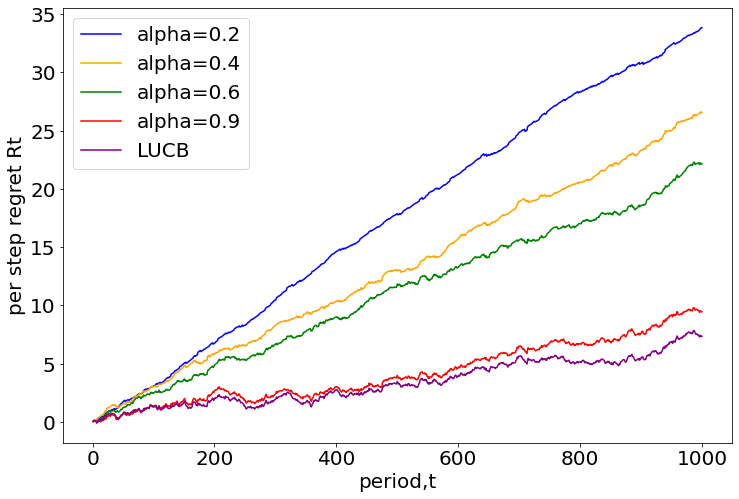

In [ ]:
for i in range(trials):
    plt.figure(figsize=(12,8))
    colors = (['blue', 'orange', 'green', 'red', 'purple'])
#     markers = ['o', '*', 's', '^', '+']
    for j in range(len(alpha_values)):
        iteration_value_t = [a*b for a,b in zip(iteration_value_trials_1[i][j],[k+1 for k in range(iterations)])]
        plt.plot([k+1 for k in range(iterations)], iteration_value_t, label=('alpha='+str(alpha_values[j])), color=colors[j])
        np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure1/save_figure_alpha_'+str(alpha_values[j])+'.npz', x=[k+1 for k in range(iterations)], y=iteration_value_t)
#         plt.scatter([k+1 for k in range(iterations)], iteration_value_t, marker=markers[j])
    LUCB_value_t = [a*b for a,b in zip(per_trial_LUCB[i][1],[k+1 for k in range(iterations)])]
    plt.plot([k+1 for k in range(iterations)], LUCB_value_t, label=('LUCB'), color=colors[-1])
    np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure1/save_figure_LUCB_value_t.npz', x=[k+1 for k in range(iterations)], y=LUCB_value_t)
#     plt.scatter([k+1 for k in range(iterations)], LUCB_value_t, marker=markers[-1])
    plt.xlabel('period,t', fontsize=20)
    plt.ylabel('per step regret Rt', fontsize=20)
    plt.legend()
    plt.savefig('Figure1.jpg')
    plt.show()
    plt.close()

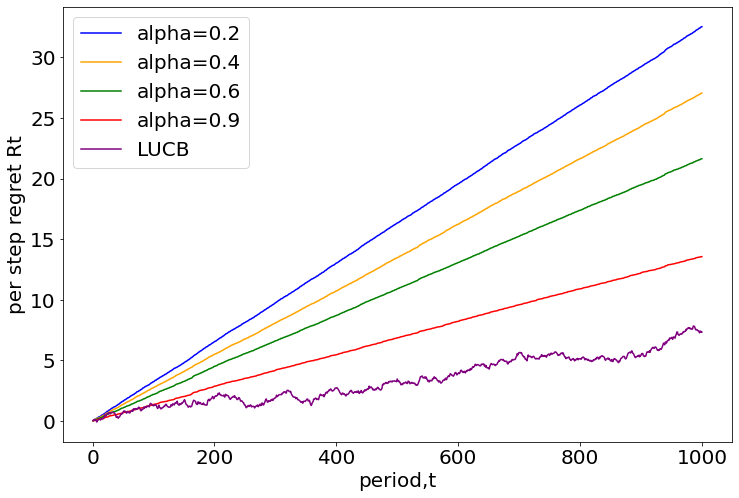

In [ ]:
for i in range(trials):
    plt.figure(figsize=(12,8))
    colors = (['blue', 'orange', 'green', 'red', 'purple'])
    markers = ['o', '*', 's', '^', '+']
    for j in range(len(alpha_values)):
        iteration_value_t = [a*b for a,b in zip(iteration_value_trials_3[i][j],[k+1 for k in range(iterations)])]
        plt.plot([k+1 for k in range(iterations)], iteration_value_t, label=('alpha='+str(alpha_values[j])), color=colors[j])
        np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure2/save_figure_alpha_'+str(alpha_values[j])+'.npz', x=[k+1 for k in range(iterations)], y=iteration_value_t)
#         plt.scatter([k+1 for k in range(iterations)], iteration_value_t, marker=markers[j])
    LUCB_value_t = [a*b for a,b in zip(per_trial_LUCB[i][1],[k+1 for k in range(iterations)])]
    plt.plot([k+1 for k in range(iterations)], LUCB_value_t, label=('LUCB'), color=colors[-1])
    np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure2/save_figure_LUCB_value_t.npz', x=[k+1 for k in range(iterations)], y=LUCB_value_t)
#     plt.scatter([k+1 for k in range(iterations)], LUCB_value_t, marker=markers[-1])
    plt.xlabel('period,t', fontsize=20)
    plt.ylabel('per step regret Rt', fontsize=20)
    plt.legend()
    plt.savefig('Figure2.jpg')
    plt.show()
    plt.close()

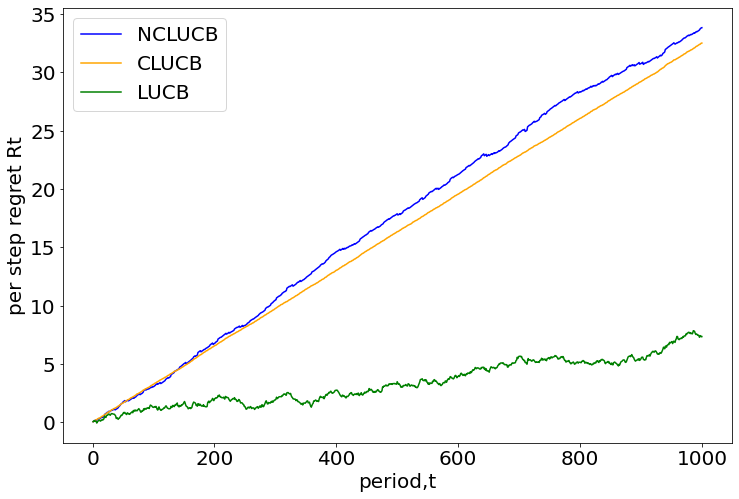

In [ ]:
for i in range(trials):
    plt.figure(figsize=(12,8))
    colors = (['blue', 'orange', 'green'])
    markers = ['o', '*', 's']
    iteration_value_1_t = [a*b for a,b in zip(iteration_value_trials_1[i][0],[k+1 for k in range(iterations)])]
    plt.plot([k+1 for k in range(iterations)], iteration_value_1_t, label='NCLUCB', color=colors[0])
    np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure3/save_figure_NCLUCB.npz', x=[k+1 for k in range(iterations)], y=iteration_value_1_t)
#     plt.scatter([k+1 for k in range(iterations)], iteration_value_1_t, marker=markers[0])
    iteration_value_3_t = [a*b for a,b in zip(iteration_value_trials_3[i][0],[k+1 for k in range(iterations)])]
    plt.plot([k+1 for k in range(iterations)], iteration_value_3_t, label='CLUCB', color=colors[1])
    np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure3/save_figure_CLUCB.npz', x=[k+1 for k in range(iterations)], y=iteration_value_3_t)
#     plt.scatter([k+1 for k in range(iterations)], iteration_value_3_t, marker=markers[1])
    LUCB_value_t = [a*b for a,b in zip(per_trial_LUCB[i][1],[k+1 for k in range(iterations)])]
    plt.plot([k+1 for k in range(iterations)], LUCB_value_t, label='LUCB', color=colors[-1])
    np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure3/save_figure_LUCB.npz', x=[k+1 for k in range(iterations)], y=LUCB_value_t)
#     plt.scatter([k+1 for k in range(iterations)], LUCB_value_t, marker=markers[-1])
    plt.xlabel('period,t', fontsize=20)
    plt.ylabel('per step regret Rt', fontsize=20)
    plt.legend()
    plt.savefig('Figure3.jpg')
    plt.show()
    plt.close()

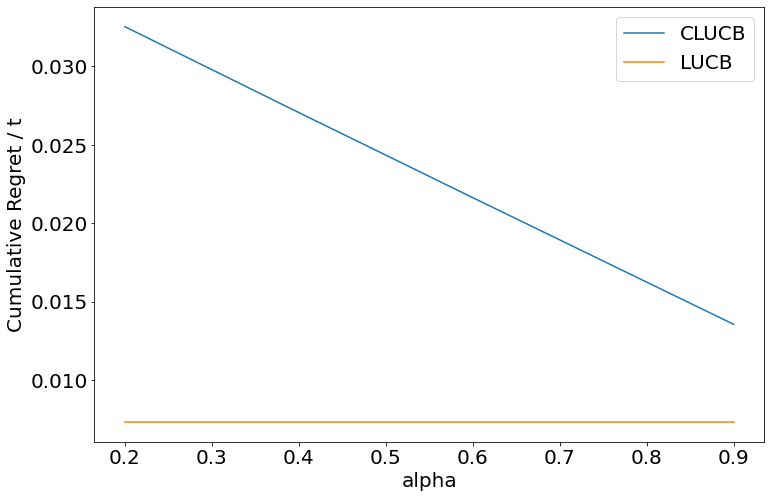

In [ ]:
for i in range(trials):
    plt.figure(figsize=(12,8))
    plt.plot(alpha_values, last_value_trials[i], label=('CLUCB'))
    np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure4/save_figure_CLUCB.npz', x=alpha_values, y=last_value_trials[i])
#     plt.scatter(alpha_values, last_value_trials[i], marker='x')
    plt.plot(alpha_values, value_LUCB_trials[i], label=('LUCB'))
    np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure4/save_figure_LUCB.npz', x=alpha_values, y=value_LUCB_trials[i])
#     plt.scatter(alpha_values, value_LUCB_trials[i], marker='x')
    plt.xlabel('alpha', fontsize=20)
    plt.ylabel('Cumulative Regret / t', fontsize=20)
    plt.legend()
    plt.savefig('Figure4.jpg')
    plt.show()
    plt.close()

No handles with labels found to put in legend.


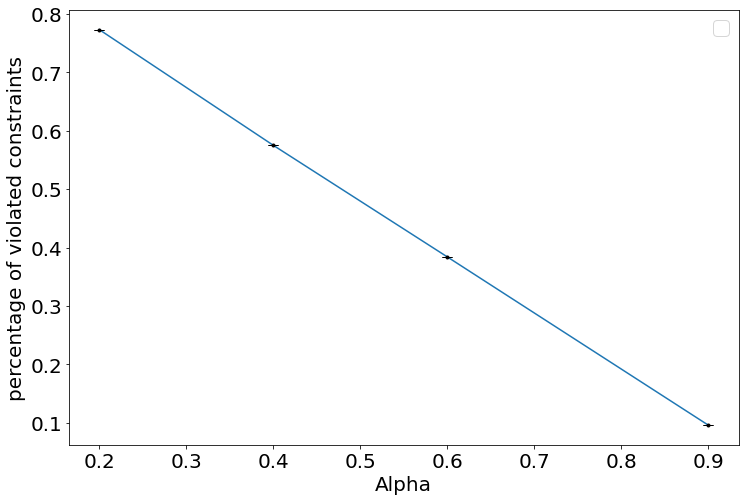

In [ ]:
x = [item[0] for item in per_alpha_constraint_violation_1]
avg_constraint_violation_1 = [np.mean(item[1]) for item in per_alpha_constraint_violation_1]
std_constraint_violation_1 = [np.std(item[1]) for item in per_alpha_constraint_violation_1]

plt.figure(figsize=(12,8))
plt.plot(x, avg_constraint_violation_1)
np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure5/save_figure_avg_constraint_violation.npz', x=x, y=avg_constraint_violation_1)
plt.errorbar(x, avg_constraint_violation_1, yerr=std_constraint_violation_1, fmt='.k', capsize=5)
np.savez('C:/Users/jiabin/Dropbox/Jiabin/Bandit/Figure5/save_figure_errorbar.npz', x=x, y=avg_constraint_violation_1, z=std_constraint_violation_1)

plt.ylabel('percentage of violated constraints', fontsize=20)
plt.xlabel('Alpha', fontsize=20)
plt.legend()
plt.savefig('Figure5.jpg')
plt.show()
plt.close()